## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [3]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from random import sample
import re

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
#if not os.path.exists('sonnets.txt'):
    #!wget https://github.com/EvgenVer/ml_course/tree/main/homeworks/lab02_deep_learning/sonnets.txt
#text=[]

#with open('sonnets.txt', 'r') as iofile:
    #text.append(iofile.readlines())

#TEXT_START = 45
#TEXT_END = -368
#text = text[TEXT_START : TEXT_END]
#assert len(text) == 2616"

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

### Data loading: "Евгений Онегин"


In [6]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]
text = [re.sub(r'([[].+[]])', '', x) for x in text]
text = [re.sub(r'[\s][\s]+', '', x) for x in text]

--2023-09-21 18:57:58--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.04s   

2023-09-21 18:57:59 (5.97 MB/s) - ‘onegin.txt’ saved [262521/262521]



<ipython-input-6-3b953e2e93b9>:7: FutureWarning: Possible nested set at position 2
  text = [re.sub(r'([[].+[]])', '', x) for x in text]


In [7]:
MAX_LENGTH = max(map(len, text))
MAX_LENGTH

49

In [8]:
len(text)

7088

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [9]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [10]:
tokens = sorted(list(set(text)))
num_tokens = len(tokens)
print(f'num_tokens = {num_tokens}')
print(tokens)

num_tokens = 78
['\n', ' ', '!', '(', ')', ',', '-', '.', '5', ':', ';', '?', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '’', '…', '€']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [11]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {index: char for index, char in enumerate(tokens)}

print(token_to_idx)
print(idx_to_token)

{'\n': 0, ' ': 1, '!': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '5': 8, ':': 9, ';': 10, '?': 11, '^': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37, '«': 38, '»': 39, 'а': 40, 'б': 41, 'в': 42, 'г': 43, 'д': 44, 'е': 45, 'ж': 46, 'з': 47, 'и': 48, 'й': 49, 'к': 50, 'л': 51, 'м': 52, 'н': 53, 'о': 54, 'п': 55, 'р': 56, 'с': 57, 'т': 58, 'у': 59, 'ф': 60, 'х': 61, 'ц': 62, 'ч': 63, 'ш': 64, 'щ': 65, 'ъ': 66, 'ы': 67, 'ь': 68, 'э': 69, 'ю': 70, 'я': 71, 'ё': 72, '–': 73, '—': 74, '’': 75, '…': 76, '€': 77}
{0: '\n', 1: ' ', 2: '!', 3: '(', 4: ')', 5: ',', 6: '-', 7: '.', 8: '5', 9: ':', 10: ';', 11: '?', 12: '^', 13: 'a', 14: 'b', 15: 'c', 16: 'd', 17: 'e', 18: 'f', 19: 'g', 20: 'h', 21: 'i', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w',

In [12]:
def encod(sec):
    encod_sec = [token_to_idx[s] for s in sec]
    return encod_sec

In [13]:
batch = encod(text[:128])
embed = nn.Embedding(78, 20)
res = embed(torch.LongTensor(batch))
res.size(0)

128

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [15]:
# Your code here
class CharRNNCell(nn.Module):

    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=128):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = torch.tanh(self.rnn_update(x_and_h))

        assert h_next.size() == h_prev.size()

        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)




In [16]:
def rnn_loop(char_rnn, batch_ix):
    batch_size = batch_ix.size(0)
    hid_state = char_rnn.initial_state(batch_size).to(device)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)
        logits.append(logits_next)

    return torch.stack(logits, dim=1)

In [139]:
#char_rnn = CharRNNCell()
#batch_ix = encod(text[:128])
#batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
#batch_ix = batch_ix.view(1,128)
#logit_seq = rnn_loop(char_rnn, batch_ix)
#print(batch_ix[:, 1:].size())
#print(logit_seq.size())
#print(logit_seq[:, :-1].size())
#print(batch_ix[:,1:].size())

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [22]:
# Your plot code here
char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()

loss_history = []
n_epochs = 100
batch_size = 256


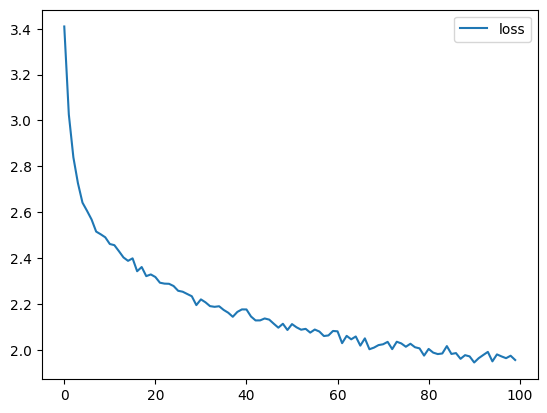

In [23]:
for ep in range(n_epochs):
    ep_loss = []
    for i in range(len(text) % batch_size):
        start_batch = np.random.randint(0, len(text)-batch_size-1)
        batch = encod(text[start_batch:start_batch+batch_size])
        batch = torch.tensor(batch, dtype=torch.int64)
        batch = batch.view(1, batch_size)
        batch = batch.to(device)

        logits_seq = rnn_loop(char_rnn, batch)

        pred_logits = logits_seq[:, :-1]
        actual_next_tokens = batch[:, 1:]

        loss = loss_func(
            pred_logits.reshape((-1, num_tokens)),
            actual_next_tokens.reshape(-1)
        )

        loss.backward()
        opt.step()
        opt.zero_grad()

        ep_loss.append(loss.item())

    loss_history.append(np.mean(ep_loss))

    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()


assert np.mean(loss_history[:10]) > np.mean(loss_history[-10:]), "RNN didn't converge."




In [24]:
def generate_sample(char_rnn, seed_phrase='Герой', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).to('cpu').data.numpy()[0]

        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        #print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.to('cpu').data.numpy()[0]])

In [25]:
print(generate_sample(char_rnn=char_rnn, seed_phrase='герой', max_length=700, temperature=0.5))

герой она повет,
и столость и все он мой сей,
под вор два строкой,
когда как и постит,
отенье в и посторой
сердце вольно моей!



xxii

куда старой от долго томной
и сердце долже замена.
перед весть он сему последный не полей
и мертал, оканала,
и нет и стельный кругом,
замечь молчалось онегинец я темерку романа
татьяна ваши, тем сердце ли когда сам столов
ее сменил и старинье переду предовин,
придет он полет,
татьяна своей двор.



vi

но как и в комей не страченный достом
замодной ленский порой
и в ужался с кладельный полной
под верна естан бестриталый,
на волнит безмолод,
и в горой, с как полный,
потя не молобовать подвузава,
я молча своей постое
да был светельной,
как возна своей с ней со


In [50]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=18, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(input_size=emb_size,
                          hidden_size=rnn_num_units,
                          batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

model = CharRNNLoop().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
loss_history = []
n_epochs = 200
batch_size = 256



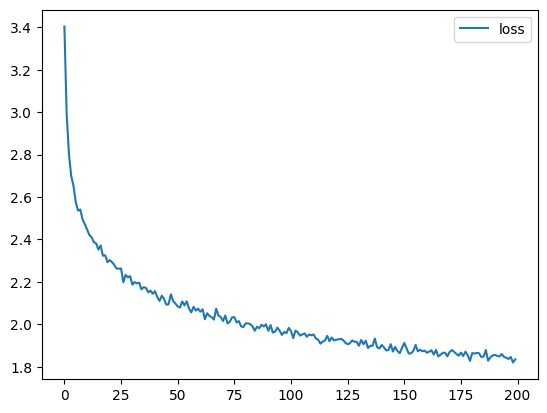

In [51]:
for ep in range(n_epochs):
    ep_loss = []
    for i in range(len(text) % batch_size):
        start_batch = np.random.randint(0, len(text)-batch_size-1)
        batch = encod(text[start_batch:start_batch+batch_size])
        batch = torch.tensor(batch, dtype=torch.int64)
        batch = batch.view(1, batch_size)
        batch = batch.to(device)

        logits_seq = model(batch)

        pred_logits = logits_seq[:, :-1]
        actual_next_tokens = batch[:, 1:]


        loss = loss_func(
            pred_logits.reshape((-1, num_tokens)),
            actual_next_tokens.reshape(-1)
        )

        loss.backward()
        opt.step()
        opt.zero_grad()

        ep_loss.append(loss.item())

    loss_history.append(np.mean(ep_loss))

    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()

In [52]:
def generate_sample(model, max_length, seed_phrase='Герой', temperature=1.0):

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        model(x_sequence[:, i])

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out = model(x_sequence[:, -1])
        p_next = F.softmax(out / temperature, dim=-1).to('cpu').data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.to('cpu').data.numpy()[0]])

In [55]:
print(generate_sample(model, max_length=700, seed_phrase='герой', temperature=0.5))

герой ей ва иной поно бой по но но ного нотого ль пой ско стой пра поного вой погино болахо м да пота ней нала ско скаласкотоной тоней да сто во пей понела ско вой пей бо но хотозва валь исто пра ной ва ной во ся лихо богогого то во илугогоной скоту,
пей но скобой ной ной ско но хо по пробо вы стотужей вы
ной во погинужиней пра вихо поду но нето вогой пой вой бы
ой пой то бы,
побей быно скодали скобо пей стахотоней ско, вало ны
то ско стокой стоней ско ихо ой ско ва бы,

ногим?» ной маскода бо го посты но да далала, ска м но по по поко нухобе в ско сконото стыноты ско но в сель скону, спралала валиной во пей бей пла ной в во нотей но но пичалахо стичи,
но и, бо визала ной но о прастой в вско


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)